<table style="background-color: transparent;">
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%" align="center"><font size="7" color="#7748a4"> Práctica 3. Algoritmos Cuánticos I</font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="4" color="black">Computación Cuántica</font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="4" color="black">2025-2</font></td>
    </tr>
</table>

<p style="text-align:center; font-weight:bold;">Nombre del Alumno: Rosario Vázquez José André</p>
<p style="text-align:center; font-weight:bold;">Núm. Cuenta: 318353351

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\mymatrix}[2]{\left[ \begin{array}{#1} #2\end{array} \right]} $
$ \newcommand{\myvector}[1]{\mymatrix{c}{#1}} $

<a id="1"></a>
# Desarrollo

#### 1. Codifica una función llamada teleportacion que cumpla con lo siguiente:

   1. Reciba parámetros para preparar el estado a ser teleportado.
   2. Reciba otro parámetro que indique que estado de Bell se debe usar para entrelazar los qubits de Alicia y de Bob. Preparar el estado de Bell correspondiente.
   3. Aplique las compuertas correctas en la decodificación dependiendo del estado de Bell indicado como parámetro.
   4. Muestre el circuito creado con el protocolo de Teleportación completo con los parámetros provistos.
      - Recuerda que puedes usar la función `display` para que el `.draw()` del circuito se vea (hay ejemplos de esto en los notebooks).
   5. Muestre una esfera de Bloch con el estado a ser enviado (usar función `display`). El estado lo puedes obtener con `Statevector` (ver Lab1).
   6. Simulación del circuito usando la clase `BasicSimulator` (como en el ejemplo de este Lab3).
      - Está prohibido usar Qiskit Aer (`qiskit-aer`). Muchos ejemplos en internet usan Qiskit Aer, pero no se puede usar en las tareas, así que realiza la adecuación pertinente del código.

##### Función selectora de estado

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_vector, plot_histogram, plot_bloch_multivector

from qiskit.providers.basic_provider import BasicSimulator
from qiskit.result import marginal_counts
import numpy as np
from numpy import pi, random
from IPython.display import display

def estado_bell(circuito, q0, q1, tipo_bell):
    if tipo_bell == '1':
        circuito.h(q0)
        circuito.cx(q0, q1)
    elif tipo_bell == '2':
        circuito.x(q0)
        circuito.h(q0)
        circuito.cx(q0, q1)
    elif tipo_bell == '3':
        circuito.x(q1)
        circuito.h(q0)
        circuito.cx(q0, q1)
    elif tipo_bell == '4':
        circuito.x(q0)
        circuito.x(q1)
        circuito.z(q1)
        circuito.h(q0)
        circuito.cx(q0, q1)
    else:
        raise ValueError("Estado de Bell no válido. Usar: 1,2,3,4")

def teleportacion(theta, phi, lam, tipo_bell):
    # Estado cuántico -  Lo que se ve a enviar
    circ_temp = QuantumCircuit(1)                                  # circuito con solo el estado a enviar
    circ_temp.u(theta, phi, lam, 0)                                # aplicar los ángulos aleatorios al único qubit
    
    psi_state = Statevector(circ_temp)                             # obtenemos el vector de estado para visualizarlo

    # -----  Esfera de Bloch ----- 
    display(psi_state.draw('latex', prefix="|\\psi\\rangle ="))    # mostrar en notación de Dirac
    display(plot_bloch_multivector(psi_state))                     # mostrar en esfera de Bloch    

    # Configuración del protocolo completo
    #Configuracion inical
    qr_alicia = QuantumRegister(2, name="alicia")  # dos qubits de Alicia
    qr_bob = QuantumRegister(1, name="bob")        # un qubit de Bob
    crz = ClassicalRegister(1, name="crz")         # 2 bits clasicos
    crx = ClassicalRegister(1, name="crx")         # en 2 diferentes registros
    bob_med = ClassicalRegister(1, name="bob_med")

    circuito_teleportacion = QuantumCircuit(qr_alicia, qr_bob, crz, crx, bob_med)

    #Paso 0: Inicar el qbit con el estado a enviar
    circuito_teleportacion.u(theta, phi, lam, [qr_alicia[0]])   # rotar el qubit 0 de alicia con los ángulos aleatorios
    circuito_teleportacion.barrier()

    #Paso 1: Crear el par entrelazado
    estado_bell(circuito_teleportacion, qr_alicia[1], qr_bob[0], tipo_bell)  #Circuito qbit a, qbit b
    circuito_teleportacion.barrier()

    #Paso 2: "Enviar" q1 a Alicia y q2 a Bob
    circuito_teleportacion.cx(qr_alicia[0], qr_alicia[1])
    circuito_teleportacion.h(qr_alicia[0])

    #Paso 3: Alicia envía sus bits clásicos a Bob
    circuito_teleportacion.barrier()
    circuito_teleportacion.measure(qr_alicia[0],crz[0])
    circuito_teleportacion.measure(qr_alicia[1],crx[0])

    #Paso 4: Bod decodifica su qbit
    circuito_teleportacion.barrier()
    circuito_teleportacion.x(qr_bob[0]).c_if(crx, 1)
    circuito_teleportacion.z(qr_bob[0]).c_if(crz, 1)

    #Finalmente, medir el qbit de Bob (en otro qbit)
    circuito_teleportacion.barrier()
    circuito_teleportacion.measure(qr_bob[0], bob_med)
    
    # Mostrando Circuito
    display(circuito_teleportacion.draw('mpl'))

    #Simulando Resultados
    sim_basic = BasicSimulator()                                  # usamos el simulador básico

    # Circuito con el estado cuántico a enviar
    cirq_enviar = QuantumCircuit(1, 1)
    cirq_enviar.u(theta, phi, lam, 0)
    cirq_enviar.measure(0, 0)

    # simulamos el circuito con solo el estado a enviar y el que hará la teleportación
    job_enviar = sim_basic.run(cirq_enviar)    
    job_teleportacion = sim_basic.run(circuito_teleportacion)    

    #Obteniendo conteos
    conteos = job_teleportacion.result().get_counts()

    #Solo nos interan los resultados del qbit de Bob, que es indice 2
    tele_counts = marginal_counts(conteos, [2])                  

    #Graficando con un histograma
    legend = ["Estado original", "Estado teleportado"]
    display(plot_histogram([job_enviar.result().get_counts(), tele_counts], legend=legend))

    

##### Prueba con el primer estado de Bell $\Phi^+$

<IPython.core.display.Latex object>

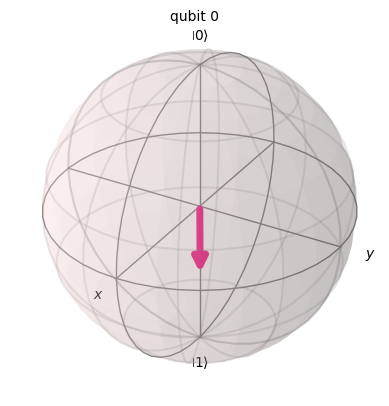

C:\Users\andre\AppData\Local\Temp\ipykernel_13964\2825682861.py:72: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito_teleportacion.x(qr_bob[0]).c_if(crx, 1)
C:\Users\andre\AppData\Local\Temp\ipykernel_13964\2825682861.py:73: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito_teleportacion.z(qr_bob[0]).c_if(crz, 1)


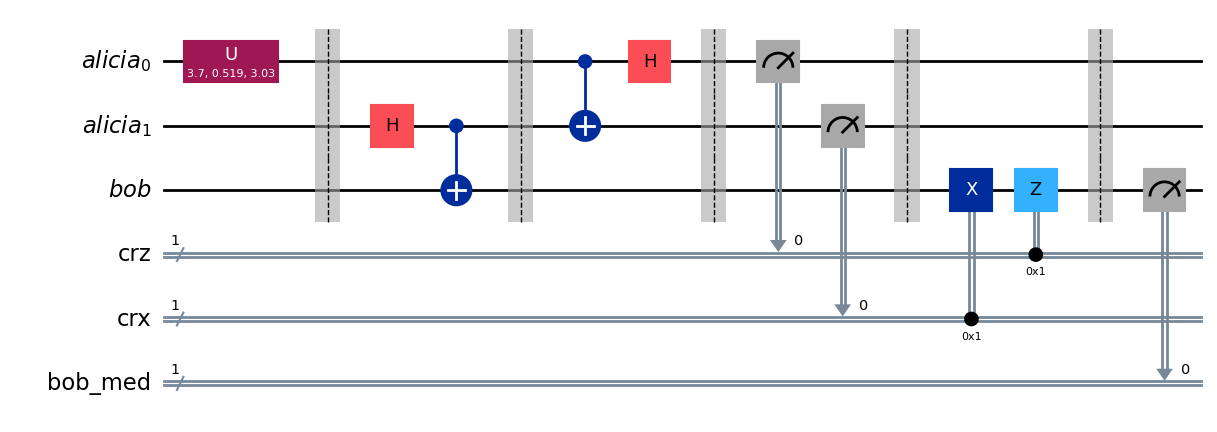

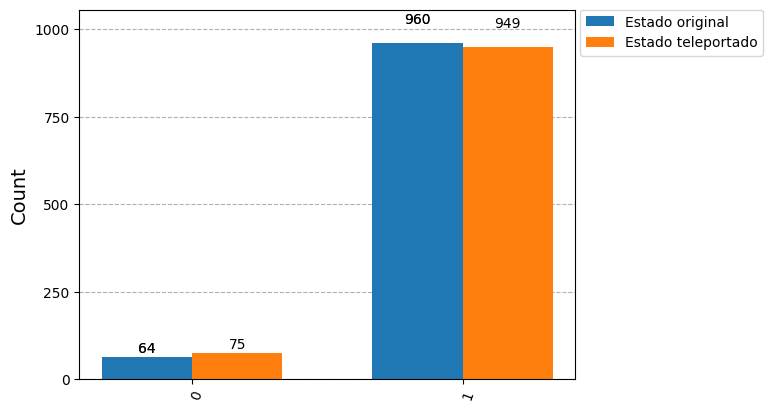

In [7]:
# Generando 3 angulos al azar
theta = random.random() * 2 * pi
phi = random.random() * 2 * pi
lam = random.random() * 2 * pi

teleportacion(theta, phi, lam, '1')

##### Prueba con el segundo estado de Bell $\Phi^-$

<IPython.core.display.Latex object>

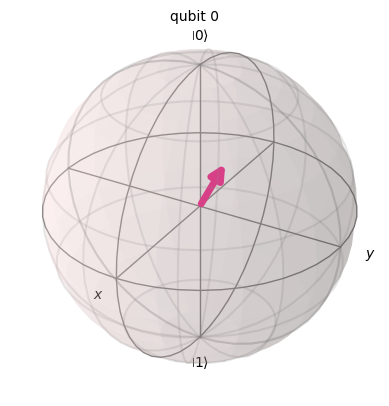

C:\Users\andre\AppData\Local\Temp\ipykernel_13964\2825682861.py:72: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito_teleportacion.x(qr_bob[0]).c_if(crx, 1)
C:\Users\andre\AppData\Local\Temp\ipykernel_13964\2825682861.py:73: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito_teleportacion.z(qr_bob[0]).c_if(crz, 1)


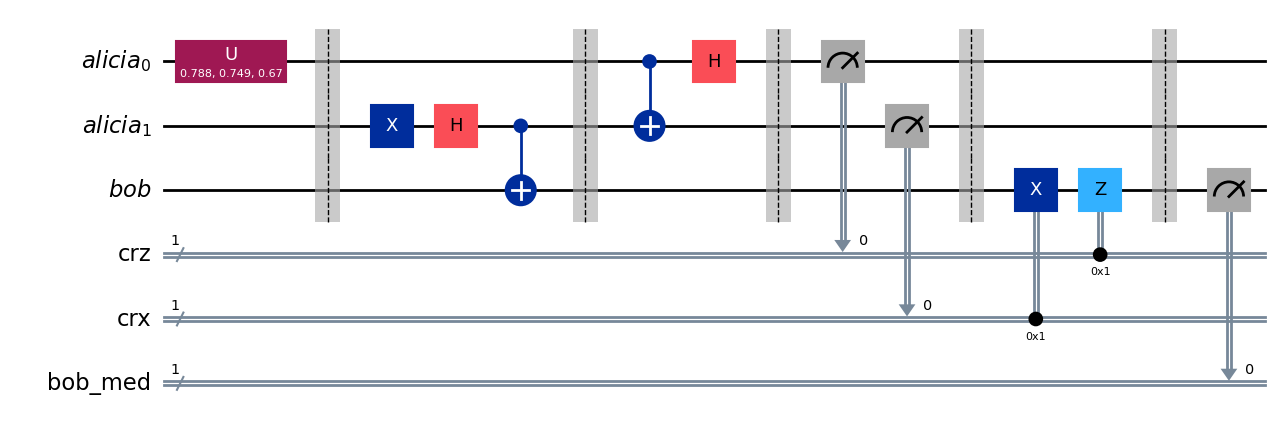

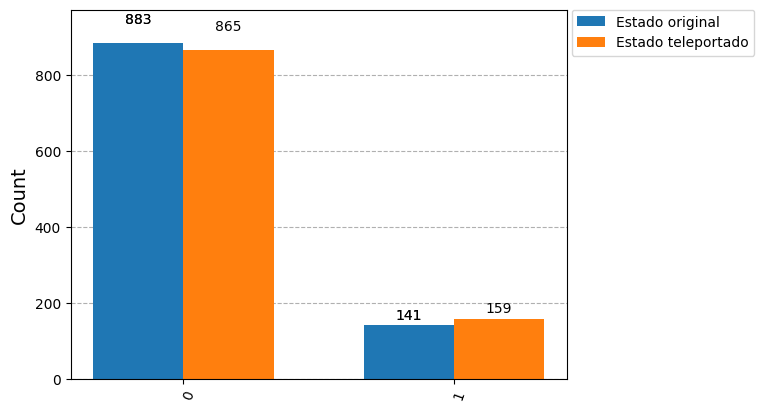

In [4]:
# Generando 3 angulos al azar
theta = random.random() * 2 * pi
phi = random.random() * 2 * pi
lam = random.random() * 2 * pi

teleportacion(theta, phi, lam, '2')

##### Prueba con el segundo estado de Bell $\Psi^+$

<IPython.core.display.Latex object>

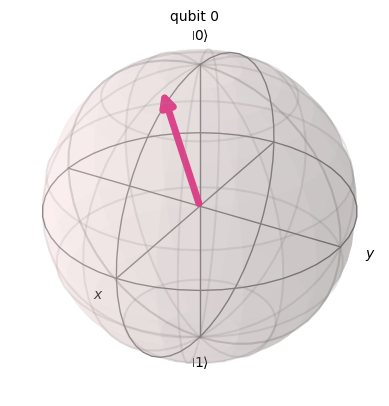

C:\Users\andre\AppData\Local\Temp\ipykernel_13964\2825682861.py:72: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito_teleportacion.x(qr_bob[0]).c_if(crx, 1)
C:\Users\andre\AppData\Local\Temp\ipykernel_13964\2825682861.py:73: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito_teleportacion.z(qr_bob[0]).c_if(crz, 1)


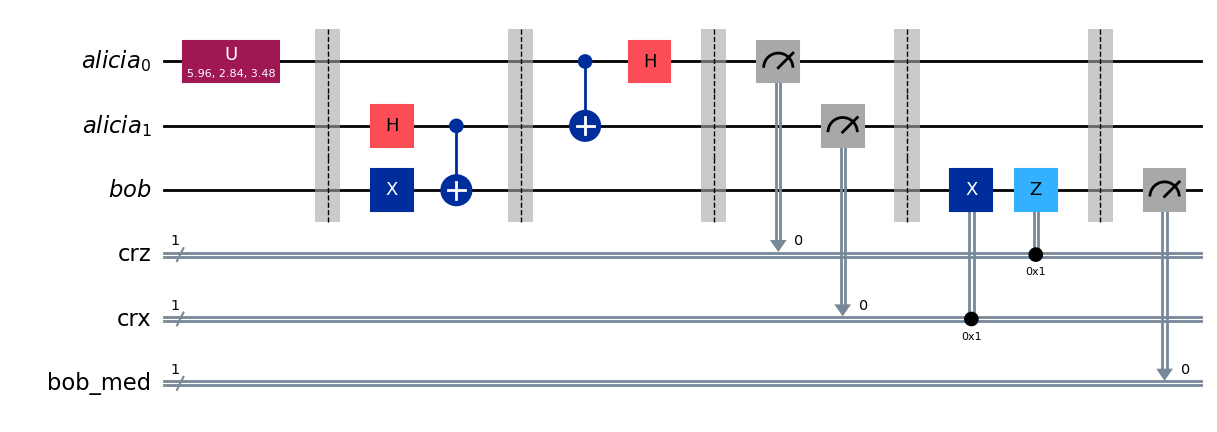

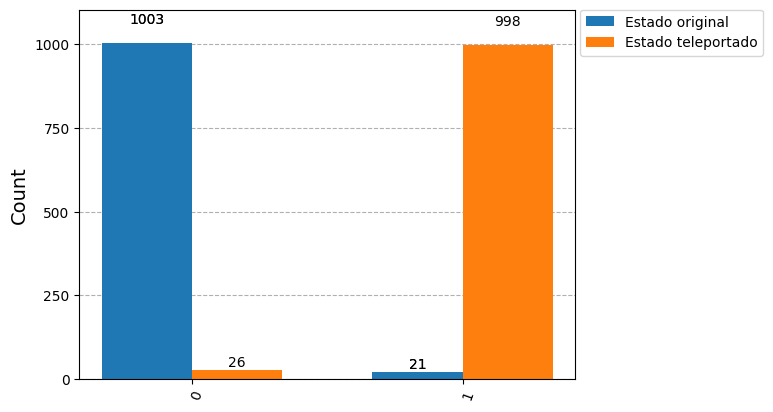

In [5]:
# Generando 3 angulos al azar
theta = random.random() * 2 * pi
phi = random.random() * 2 * pi
lam = random.random() * 2 * pi

teleportacion(theta, phi, lam, '3')

##### Prueba con el segundo estado de Bell $\Psi^-$

<IPython.core.display.Latex object>

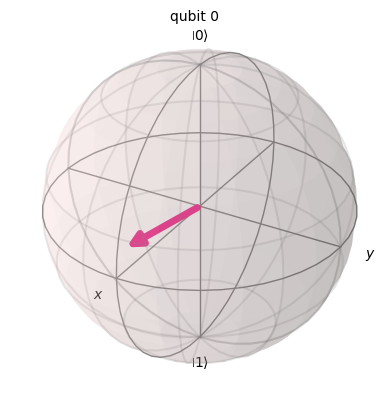

C:\Users\andre\AppData\Local\Temp\ipykernel_13964\2825682861.py:72: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito_teleportacion.x(qr_bob[0]).c_if(crx, 1)
C:\Users\andre\AppData\Local\Temp\ipykernel_13964\2825682861.py:73: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito_teleportacion.z(qr_bob[0]).c_if(crz, 1)


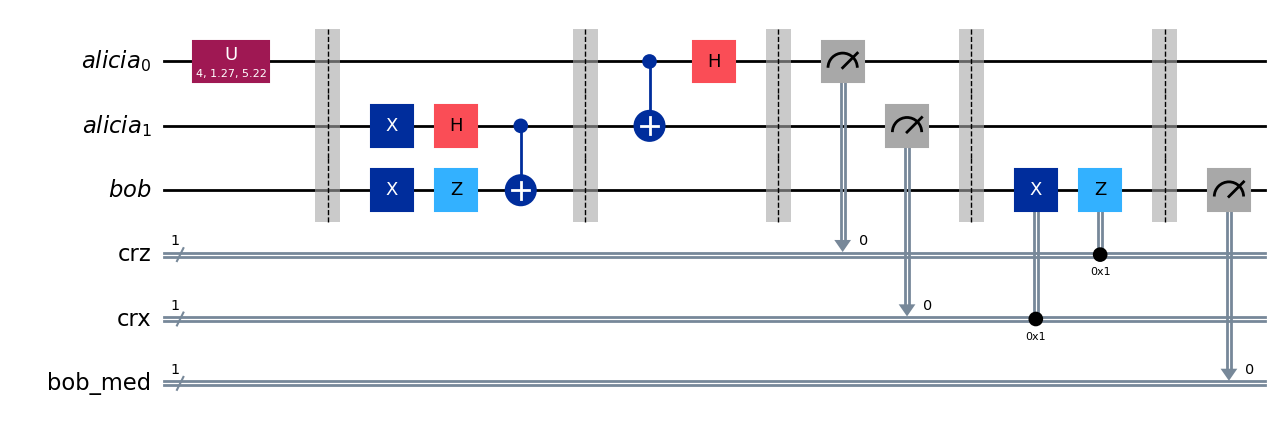

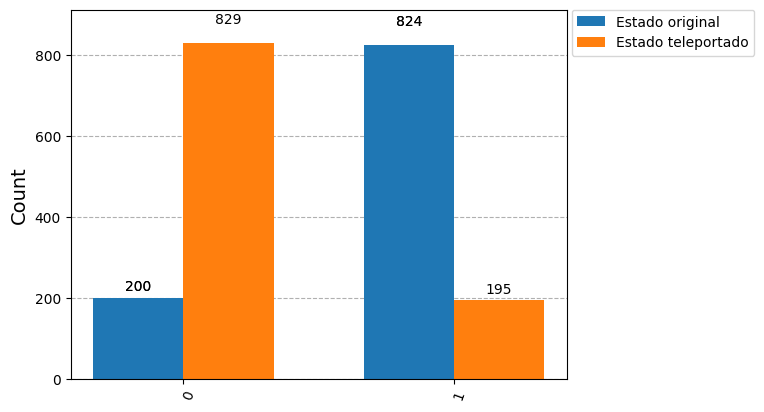

In [6]:
# Generando 3 angulos al azar
theta = random.random() * 2 * pi
phi = random.random() * 2 * pi
lam = random.random() * 2 * pi

teleportacion(theta, phi, lam, '4')

#### 2. Implementa el protocolo de codificación superdensa usando el paquete spinqit y simúlalo

1. Escribe el código en `spinqit`.
    - Hay ejemplos de código con `spinqit` en el notebook del Lab2.
    - El protocolo de codificación superdensa está completo en este mismo notebook (Lab3), solo hay que escribirlo ahora en `spinqit`.
3. Realiza la simulación en tu computadora usando `BasicSimulatorConfig` (como en los ejemplos).
    - Recuerda que debes tener un ambiente con Python 3.8 y el framework `spinqit` instalado.
4. Debes mostrar los resultados de este ejercicio 2 en el mismo notebook en el que están los resultados del ejercicio 1.
    - Puedes hacer el ejercicio 1 en un ambiente de conda y guardar el notebook.
    - Luego abrir el notebook de nuevo en un segundo ambiente y realizar este ejercicio 2 en ese segundo ambiente, solo no toques las celdas de tus respuesta del ejercicio 1.



{'01': 1024}
{'01': 0.9999999999239011}
[0j, (1+0j), 0j, 0j]



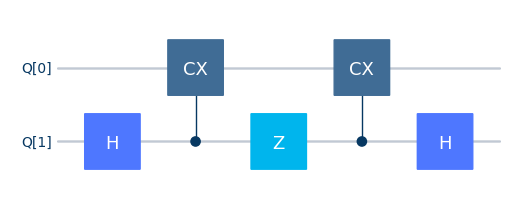

In [3]:
from spinqit import Circuit
from spinqit import H, X, Z, CX
from spinqit import get_basic_simulator, get_compiler, BasicSimulatorConfig
from spinqit import draw
from spinqit.utils import print_circuit

#Paso 1: Creando el par de Bell
def crear_par_de_bell():
    qc = Circuit()
    q = qc.allocateQubits(2)
    #Not: de los 2 qbits -> q[1] Alicia, q[0] Bob
    qc << (H, q[1])
    qc << (CX, (q[1], q[0]))
    return qc, q

#Paso 2: Codificar bits clásicos - Aplicando compuertas cuánticas
def codificar_mensaje(qc, qubit, msg):
    #El mensaje solo debe ser de solo 0s y 1s
    if len(msg) != 2 or not set(msg).issubset({"0", "1"}):
        raise ValueError(f"El mensaje '{msg}' es inválido")
    # Si es '1' el de más a la derecha en el mensaje
    if msg[1] == "1":
        qc << (X, qubit)
    #Si es '1' el de más a la izquierda en el mensaje
    if msg[0] == "1":
        qc << (Z, qubit)
    return qc
    
#Paso 3: Decodificación del mensaje de Alicia
def decodificar_mensaje(qc, q):
    qc << (CX, (q[1], q[0]))
    qc << (H, q[1])
    return qc

#Protocolo Completo

#Carlos crea un par entrelazado entre Alcia y Bob
qc, q = crear_par_de_bell()

#En este punto, el qubit 1 va a Alicia y el qubit 0 va a Bob
#Alicia codifica su mensaje en el qbit 1.
#Se puede cambiar el valor del cicuito
mensaje = '10'
qc = codificar_mensaje(qc, q[1], mensaje)

#Alicia envía su qbit a Bob
#Despues de recibir el qbit 1, Bob aplica el protocolo de recuperacion
qc = decodificar_mensaje(qc,q)

#Compilando Circuito
comp = get_compiler()
engine = get_basic_simulator()
exe = comp.compile(qc, 0)

#Viendo Circuito
draw(exe)

#Simulando Resultados 
config = BasicSimulatorConfig()
config.configure_shots(1024)
result = engine.execute(exe, config)

#Obtener y mostrar resultados
print(result.counts)
#Obtener y mostar resultados
print(result.probabilities)
#Obtener y mostrar estados
print(result.states)
print()

#### 3. Codifica los 4 estados de Bell en spinqit y simúlalos

1. Escribe el código en `spinqit`.
    - Hay ejemplos de código con `spinqit` en el notebook del Lab2.
    - Los estados de Bell y sus circuitos están en el notebook del Lab2.
3. Realiza la simulación en tu computadora usando `BasicSimulatorConfig` (como en los ejemplos).
    - Recuerda que debes tener un ambiente con Python 3.8 y el framework `spinqit` instalado.
4. Debes mostrar los resultados de este ejercicio 3 en el mismo notebook en el que están los resultados de los ejercicios 1 y 2.
    - Puedes hacer el ejercicio 1 en un ambiente de conda y guardar el notebook.
    - Luego abrir el notebook de nuevo en un segundo ambiente y realizar este ejercicio 3 (junto con el ejercicio 2) en ese segundo ambiente, solo no toques las celdas de tus respuesta del ejercicio 1.

##### Función para los estados de Bell

In [9]:
from spinqit import Circuit
from spinqit import H, X, Z, CX
from spinqit import get_basic_simulator, get_compiler, BasicSimulatorConfig
from spinqit import draw
from spinqit.utils import print_circuit

def estado_bell(tipo_bell):
    #Creando Circuito
    bell = Circuit()
    b = bell.allocateQubits(2)
    
    #Condicional de Seleción de estado de Bell
    if tipo_bell == '1':
        bell << (H, b[0])
        bell << (CX, (b[0], b[1]))
    elif tipo_bell == '2':
        bell << (X, b[0])
        bell << (H, b[0])
        bell << (CX, (b[0], b[1]))
    elif tipo_bell == '3':
        bell << (X, b[1])
        bell << (H, b[0])
        bell << (CX, (b[0], b[1]))
    elif tipo_bell == '4':
        bell << (X, b[0])
        bell << (X, b[1])
        bell << (Z, b[1])
        bell << (H, b[0])
        bell << (CX, (b[0], b[1]))
    else:
        raise ValueError("Estado de Bell no Válido. Usar: 1,2,3,4")
    
    #Compilando Circuito
    comp1 = get_compiler()
    engine1 = get_basic_simulator()
    exe1 = comp1.compile(bell, 0)
    
    #Viendo Circuito
    draw(exe1)
    
    #Simulando Resultados 
    config1 = BasicSimulatorConfig()
    config1.configure_shots(1024)
    result1 = engine1.execute(exe1, config1)

    #Obtener y mostrar resultados
    print("\nResultados de la medición:")
    print(result1.counts)
    #Obtener y mostar resultados
    print(result1.probabilities)
    #Obtener y mostrar estados
    print(result1.states)
    print()


##### Prueba con el primer estado de Bell $\Phi^+$


Resultados de la medición:
{'00': 512, '11': 512}
{'00': 0.4999999999809753, '11': 0.4999999999809753}
[(0.7071067811865476+0j), 0j, 0j, (0.7071067811865476+0j)]



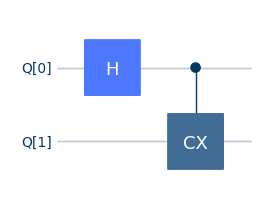

In [12]:
estado_bell('1')

##### Prueba con el segundo estado de Bell $\Phi^-$


Resultados de la medición:
{'00': 512, '11': 512}
{'00': 0.4999999999809753, '11': 0.4999999999809753}
[(0.7071067811865476+0j), 0j, 0j, (-0.7071067811865476+0j)]



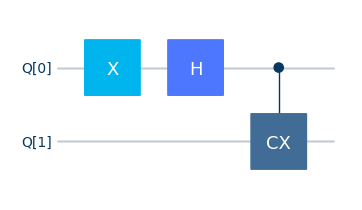

In [13]:
estado_bell('2')

##### Prueba con el segundo estado de Bell $\Psi^+$


Resultados de la medición:
{'01': 512, '10': 512}
{'01': 0.4999999999809753, '10': 0.4999999999809753}
[0j, (0.7071067811865476+0j), (0.7071067811865476+0j), 0j]



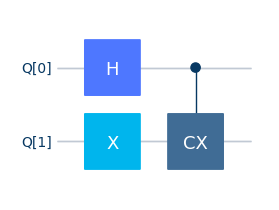

In [14]:
estado_bell('3')

##### Prueba con el segundo estado de Bell $\Psi^-$


Resultados de la medición:
{'01': 512, '10': 512}
{'01': 0.4999999999809753, '10': 0.4999999999809753}
[0j, (-0.7071067811865476-0j), (0.7071067811865476-0j), 0j]



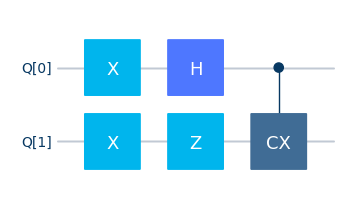

In [16]:
estado_bell('4')